<a href="https://colab.research.google.com/github/onssaadallah/Taxi-Demand-Prediction/blob/main/Poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementation of the model Time-Varying Poisson 






 **Import Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Packages**

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import csv

**Load Dataset**

In [ ]:
Data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Taxi Demand/Taxi Demand Prediction/Demand.csv')


**Exploring Data**

This data of a taxi company operating in the city of Porto, Portugal, it contains 64 taxi stands. 

In [ ]:

Data.head()



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63
0,0,0,0,0,0,1,1,0,3,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,1,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,3,0,0,1,0,1,0,3,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,2,0,0,0,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
Data.shape


(2688, 63)

**Preprocessing**

This data of a taxi company operating in the city of Porto, Portugal, contains 64 taxi stands. The preprocessing of the data  representing in  adding a new column, this column contains day type of the week(every 48 values of each  taxi stand present a day type of the week )

In [ ]:

#k: k in {0,1,2,..63}
#liste3:presents sublists of the liste1 and the length of each  sublist is 48 
day=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
def preprocessing(k,liste3):
    liste1=Data['V'+str(k)].values
    m=len(liste1)
    i=0
    liste2=[]
    
    while (i<m):
        part=[]
        part.append(liste1[i:i+48])
        liste2.append(part)
        i=i+48
    for i in range(len(liste2)):
        for k in liste2[i]:
            liste3.append(k) 
              



**Create a csv file to put the dataset in the forme(Vk |nameday |Period)**

In [ ]:
def create_data(k):
    with open('/content/drive/My Drive/Colab Notebooks/Taxi Demand/Taxi Demand Prediction/Time-varying Poisson model/Taxi1.csv', 'w', newline='') as csvfile:
        dataset=[]
        preprocessing(k,dataset)
        fieldnames = ['V'+str(k),'Day','period']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({'V'+str(k):'V'+str(k),'Day':'day','period':'period'})
        n=len(dataset)
        d=0
        for i in range(n):
            for j in range(48):
                writer.writerow({'V15':str(dataset[i][j]),'Day':day[d],'period':'P'+str(j)})
            d=d+1        
            if (d>=7):
                d=0      







In [ ]:
#In this notebook we choose the stand V15(k=15)
k=15
create_data(k)

**Load the new dataset**

In [ ]:
dataV15=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Taxi Demand/Taxi Demand Prediction/Time-varying Poisson model/Taxi.csv')
print("sahpe of the dataset: "+str(dataV15.shape))
dataV15.head()

sahpe of the dataset: (12096, 3)


,V15,day,period
0,0,Monday,P0
1,0,Monday,P1
2,1,Monday,P2
3,0,Monday,P3
4,0,Monday,P4


**data visualization (number of Taxi demande in the week)**

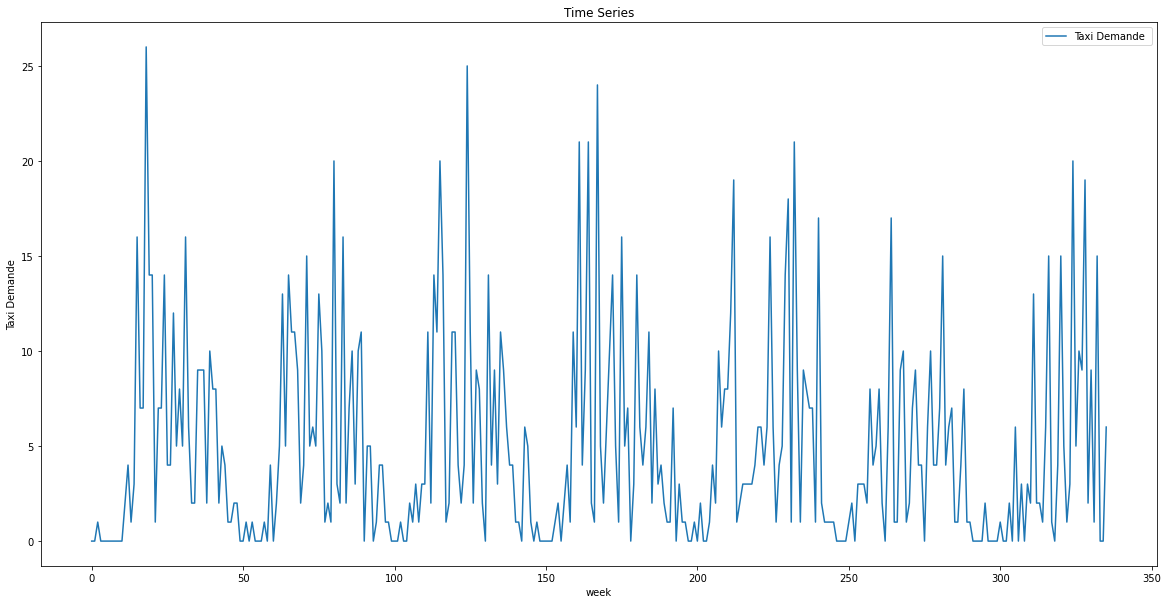

In [ ]:
plt.figure(figsize=(20,10))
ts=dataV15['V15'][:336]

plt.plot(ts,label='Taxi Demande ')

plt.title('Time Series')
plt.xlabel("week")
plt.ylabel("Taxi Demande")
plt.legend(loc='best')


**Divide the data on the Trainset and the Testset**

In [ ]:

train=dataV15[:9698]
test=dataV15[9698:len(dataV15)]

In [ ]:
#Average function
def moyenne(liste):
    return int(round(sum(liste)/len(liste)))

gathering values of taxi demandes depending daytype and the period P(t)

In [ ]:
#day: name of the day
#listep:list contains sublists of taxi demandes values according to the day(day name) and the period(P=30minuntes)
#Consedering p1(00:00-00:30) the first period in the data.
def getValues(day,p,listep=[]):
    liste=[]
    for i in range(len(train)):
        if (train['day'][i]==day) and (train['period'][i]==p):
            liste.append(train['V15'][i])
    listep.append(liste)


In [ ]:
day=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
Monday=[]#list of the taxi demande of the all Mondays.
Tuesday=[]#list of the taxi demande of the all Tuesdays.
Wednesday=[]#list of the taxi demande of  the all Wednesdays.
Thursday=[]#list of the taxi demande of the all Thursdays.
Friday=[]#list of the taxi demande of the all Fridays.
Saturday=[]#list of the taxi demande of all the Saturdays.
Sunday=[]#list of the taxi demande of  all the Sundays.
for i in day:
    if (i=='Monday'):
        for p in range(48):
            getValues(i,'P'+str(p),Monday)  
    if (i=='Tuesday'):
        for p in range(48):
            getValues(i,'P'+str(p),Tuesday) 
    if (i=='Wednesday'):
     for p in range(48):
         getValues(i,'P'+str(p),Wednesday)
    if (i=='Thursday'):
       for p in range(48):
           getValues(i,'P'+str(p),Thursday)
    if (i=='Friday') :
        for p in range(48):
            getValues(i,'P'+str(p),Friday)
    if (i=='Saturday'):
        for p in range(48):
            getValues(i,'P'+str(p),Saturday) 
    if (i=='Sunday'):
        for p in range(48):
            getValues(i,'P'+str(p),Sunday)   





**predictions:based on the historical observations in the train set, we compute the average which presents the prediction on the first day of the test set, then we update the train each 24h to predict the next day.**

In [ ]:
#list of taxi demand prediction for the first 48 periods (24h) of the test set for each day of the week.
Mondaypredictions=[]
Tuesdaypredictions=[]
Wednesdaypredictions=[]
Thursdaypredictions=[]
Fridaypredictions=[]
Saturdaypredictions=[]
Sundaypredictions=[]

In [ ]:
#d:daytype 
#liste1:list in [Monday-Sunday]
#liste2:list of predictions for the first 24h(48 periods) for each daytype.
def predict(liste1,liste2):
    for i in liste1:
        m=moyenne(i)
        liste2.append(m)



In [ ]:

for d in day:
    #prediction the first Monday in the testset
    if (d=='Monday'):
        predict(Monday,Mondaypredictions)
    if (d=='Tuesday'):
     #prediction the first Tuesday in the testset   
        predict(Tuesday,Tuesdaypredictions)
    if (d=='Wednesday'):
     #prediction the first Wednesday in the testset   
        predict(Wednesday,Wednesdaypredictions)
    if (d=='Thursday'):
      #prediction the first Thursday in the testset  
        predict(Thursday,Thursdaypredictions)
    if (d=='Friday'):
     #prediction the first Friday in the testset   
        predict(Friday,Fridaypredictions)
    if (d=='Saturday'):
       #prediction the first Saturdayin the testset 
        predict(Saturday,Saturdaypredictions)
    if (d=='Sunday'):
       #prediction the first Sunday in the testset 
        predict(Sunday,Sundaypredictions)    


**Update trainset for each 24h(48 period) with the real values of the testset and compute the predictions for the next 24h of testset**

In [ ]:
#get the real values of the testset to update the trainset each24h according to dayType(Monday,Tuesday,..,Sunday)
def getvalue(day,liste=[]):
    i=9698
    while (i<len(dataV15)):
        if (dataV15['day'][i]==day):
            liste.append(dataV15['V15'].values[i:i+48])
        i=i+48
        return liste

In [ ]:
Sundaytest=[]
Mondaytest=[]
Tuesdaytest=[]
Wednesdaytest=[]
Thursdaytest=[]
Fridaytest=[]
Saturdaytest=[]

In [ ]:
for i in day:
    if (i=='Monday'):
        getvalue(i,Mondaytest)  
    if (i=='Tuesday'):
        getvalue(i,Tuesdaytest) 
    if (i=='Wednesday'):
        getvalue(i,Wednesdaytest) 
    if (i=='Thursday'):
        getvalue(i,Thursdaytest)
    if (i=='Friday') :
        getvalue(i,Fridaytest)
    if (i=='Saturday'):
        getvalue(i,Saturdaytest) 
    if (i=='Sunday'):
        getvalue(i,Sundaytest) 

    

In [ ]:
#liste1:list of the realvalues to update the train for each day of the week
#liste2:list of the trainset for each day of the week
#liste:list of all the predictiion according to dayType
def update_day(liste1=[],liste2=[],liste=[]):
    
    j=1
    while (j<len(liste1)):
        s=[]
        for i in range(len(liste1[j])):
            liste2[i].append(liste1[j][i])
        for k in liste2:
            m=moyenne(k)
            s.append(m)
        liste.append(s)    
        j=j+1
          
           

In [ ]:
AllSundayPrediction=[]
AllMondayPrediction=[]
AllTuesdayPrediction=[]
AllWednesdayPrediction=[]
AllThursdayPrediction=[]
AllFridayPrediction=[]
AllSaturdayPrediction=[]

In [ ]:
#Fill the predictions lists with the predictions of the first 48 periods (24h) of each day of the test set.
AllSundayPrediction.append(Sundaypredictions)
AllMondayPrediction.append(Mondaypredictions)
AllTuesdayPrediction.append(Tuesdaypredictions)
AllWednesdayPrediction.append(Wednesdaypredictions)
AllThursdayPrediction.append(Thursdaypredictions)
AllFridayPrediction.append(Fridaypredictions)
AllSaturdayPrediction.append(Saturdaypredictions)

In [ ]:
#Update train set with the real values of the test set and compute the predictions for each 24h.

for i in day:
    if (i=='Monday'):
        update_day(Mondaytest,Monday,AllMondayPrediction)
    if (i=='Tuesday') :
        update_day(Tuesdaytest,Tuesday,AllTuesdayPrediction)
    if (i=='Wednesday'):
        update_day(Wednesdaytest,Wednesday,AllWednesdayPrediction)
    if (i=='Thursday'):
        update_day(Thursdaytest,Thursday,AllThursdayPrediction)
    if (i=='Friday'):
        update_day(Fridaytest,Friday,AllFridayPrediction)
    if (i=='Saturday'):
        update_day(Saturdaytest,Saturday,AllSaturdayPrediction)
    if (i=='Sunday'):
        update_day(Sundaytest,Sunday,AllSundayPrediction)                

   
  
     
  
    
   
    

**Put the predictions in the form of the dataset that we created it  to evaluate the model with different metrics**

In [ ]:
week=[]
week.append(AllSundayPrediction)
week.append(AllMondayPrediction)
week.append(AllTuesdayPrediction)
week.append(AllWednesdayPrediction)
week.append(AllThursdayPrediction)
week.append(AllFridayPrediction)
week.append(AllSaturdayPrediction)
predictions=[]
for i in range(len(week)):
    for j in range(len(week)):
        predictions.append(week[j][i])

print(predictions) 
prec=[]
for i in range(len(predictions)):
    for j in range(48):
        prec.append(predictions[i][j])


In [ ]:
#Save the predictions or the poisson model in csv file.
with open('/content/drive/My Drive/Colab Notebooks/Taxi Demand/Taxi Demand Prediction/Time-varying Poisson model/predictions_poisson_Model.csv', 'w', newline='') as csvfile:
    fieldnames = ['predictions','realvalues']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writerow({'predictions':'predictions','realvalues':'realvalues'})
    for i in range(len(prec)):
        writer.writerow({'predictions':str(prec[i]),'realvalues':str(test['V15'].values[i])})    

**Model Evaluation**

In [ ]:
#We use SMAPE and RMSE as evaluations metrics.
poisson=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Taxi Demand/Taxi Demand Prediction/Time-varying Poisson model/predictions_poisson_Model.csv')

In [ ]:
#Smape function
def smape(A, F):
    return 1/len(A) * np.sum( np.abs(F - A) / (np.abs(A) + np.abs(F)+1))


In [ ]:
#RMSE Error
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(poisson['realvalues'], poisson['predictions']))
print(rms)

3.8021319654889933


In [ ]:
smape(poisson['realvalues'],poisson['predictions'])

0.30738625564185895

**Model Visualization**

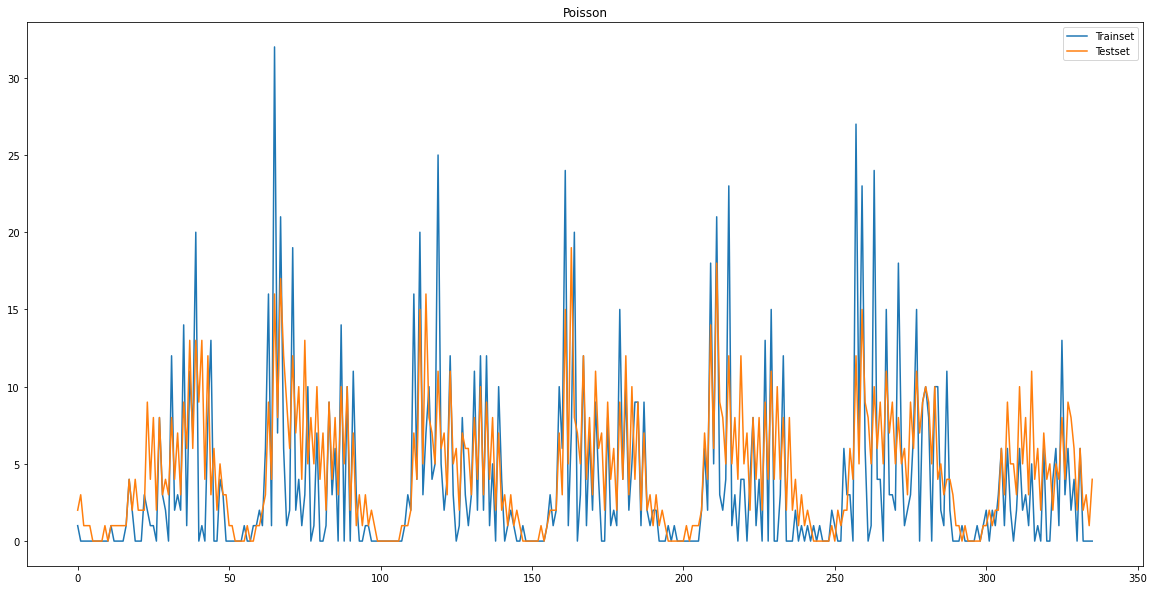

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(poisson['realvalues'][:336],label='Trainset')
plt.plot(poisson['predictions'][:336],label='Testset')
plt.legend(loc='best')
plt.title("Poisson")
plt.show()